# Requirements

- Name : Sobhan Asasi

- Student Num : 400206392

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Part A 
- Plotting one sample from each class
- Spliiting dataset to train and test (70% to 30%)

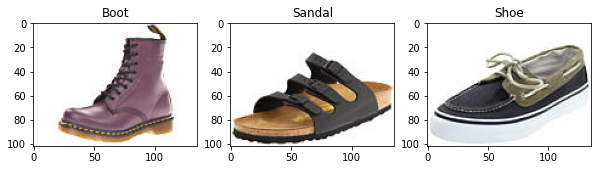

In [4]:
path = '/home/dllabsharif/Robatian/dataset/Shoe vs Sandal vs Boot Dataset'
sample_pathes = [(path + '/Boot/boot (50).jpg','Boot'),
                  (path + '/Sandal/Sandal (10).jpg','Sandal'),
                  (path + '/Shoe/Shoe (100).jpg','Shoe')]
plt.figure(figsize=(10,30))
for idx, sample in enumerate(sample_pathes):
  image_path = sample[0]
  label = sample[1]
  img = plt.imread(image_path)
  plt.subplot(int(f'13{idx+1}'))
  plt.imshow(img)
  plt.title(label)


In [5]:
tsfm = transforms.Compose([
        # Misc transforms here.
        transforms.Resize((102, 136)),
        #transforms.Resize(size=(target_size,target_size)),
        transforms.ToTensor(),
])
dataset = torchvision.datasets.ImageFolder(root=path,transform=tsfm)
print(f'The len of the dataset is {len(dataset)}')
print(f'Range of pixles in images are between {torch.min(dataset[0][0])} and {torch.max(dataset[0][0])}')
print(f'Type of the images is {dataset[0][0].dtype} and the type of labels is {type(dataset[0][1])}')
print(f'Shape of the images is {dataset[0][0].shape}')

The len of the dataset is 15000
Range of pixles in images are between 0.0 and 1.0
Type of the images is torch.float32 and the type of labels is <class 'int'>
Shape of the images is torch.Size([3, 102, 136])


In [6]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset,(train_size, test_size))
train_size = int(len(train_dataset) * 0.8)
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset,(train_size, valid_size))

print(f'The lenght of train dataset : {len(train_dataset)} ')
print(f'The lenght of valid dataset : {len(valid_dataset)} ')
print(f'The lenght of test dataset : {len(test_dataset)}')

The lenght of train dataset : 8400 
The lenght of valid dataset : 2100 
The lenght of test dataset : 4500


In [7]:
# Hyperparameters
num_classes = 3
batch_size = 64
num_epoch = 20
lr = 1e-3

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Part B
- Making MLP model

In [9]:
class neural_network(nn.Module):
    def __init__(self, inp_siz, hiden_siz, num_clases):
        super(neural_network, self).__init__()
        self.input_siz = inp_siz
        self.l1 = nn.Linear(inp_siz, hiden_siz) 
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=0.2)
        self.l2 = nn.Linear(hiden_siz, hiden_siz)
        self.l3 = nn.Linear(hiden_siz, hiden_siz)
        self.l4 = nn.Linear(hiden_siz, num_clases)
    def forward(self, y):
        y = torch.flatten(y, start_dim=1)
        outp = self.l1(y)
        outp = self.relu(outp)
        outp = self.l2(outp)
        outp = self.relu(outp)
        outp = self.l3(outp)
        outp = self.relu(outp)
        outp = self.l4(outp)
        return outp
    
nn_model = neural_network(inp_siz=3*102*136, hiden_siz=512, num_clases=3)
summary(nn_model.cuda(), input_size=(3,102,136))

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            21,307,904
├─ReLU: 1-2                              --
├─Dropout: 1-3                           --
├─Linear: 1-4                            262,656
├─Linear: 1-5                            262,656
├─Linear: 1-6                            1,539
Total params: 21,834,755
Trainable params: 21,834,755
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            21,307,904
├─ReLU: 1-2                              --
├─Dropout: 1-3                           --
├─Linear: 1-4                            262,656
├─Linear: 1-5                            262,656
├─Linear: 1-6                            1,539
Total params: 21,834,755
Trainable params: 21,834,755
Non-trainable params: 0

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, results, device="cpu"):
    y_true = []
    y_pred = []
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        y_true.extend(y.data.cpu().tolist())
        # Compute prediction and loss
        pred = model(X)
        #print(pred.shape, y.shape)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        y_pred.extend(pred.argmax(1).data.cpu().tolist())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>2f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    results['train loss'].append(train_loss)
    results['train accuracy'].append(100*correct)
    print(f"Train Metrics: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f}")
    print(f" Precision: {(100*precision_score(y_true, y_pred, average='macro')):>0.1f}%, Recall: {(100*recall_score(y_true, y_pred, average='macro')):>0.1f}%")
    return train_loss, 100*correct

def valid_loop(dataloader, model, loss_fn, results, device="cpu", mode="valid"):
    y_true = []
    y_pred = []
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            y_true.extend(y.data.cpu().tolist())
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            y_pred.extend(pred.argmax(1).data.cpu().tolist())

    test_loss /= num_batches
    correct /= size
    results['valid loss'].append(test_loss)
    results['valid accuracy'].append(100*correct)
    if mode == "valid":
        print(f"Validation Metrics: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        print(f" Precision: {(100*precision_score(y_true, y_pred, average='macro')):>0.1f}%, Recall: {(100*recall_score(y_true, y_pred, average='macro')):>0.1f}%")
        return test_loss, 100*correct
    else:
        print(f"Test Metrics: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        print(f" Precision: {(100*precision_score(y_true, y_pred, average='macro')):>0.1f}%, Recall: {(100*recall_score(y_true, y_pred, average='macro')):>0.1f}%")

In [11]:
loss_fn = nn.CrossEntropyLoss()
sgd_learning_rate = lr
sgd_opt = torch.optim.SGD(nn_model.parameters(), lr=sgd_learning_rate, momentum=0.9)

In [12]:
def train_valid(train_loader, valid_loader, loss_fn, optimizer, results, model_name, model, epochs, writer=None, device="cpu"):
    model.to(device)
    step = 0
    print(f"{model_name}\n-------------------------------")
    for t in range(epochs):
      results['epoch'].append(t+1)
      print(f"Epoch {t+1}\n-------------------------------")
      train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer, results, device=device)
      test_loss, test_acc = valid_loop(valid_loader, model, loss_fn, results, device=device)
      if writer != None:
        writer.add_scalar('Train Loss', train_loss, global_step=step)
        writer.add_scalar('Train Accuracy', train_acc, global_step=step)
        writer.add_scalar('Valid Loss', test_loss, global_step=step)
        writer.add_scalar('Valid Accuracy', test_acc, global_step=step)
        step += 1
      print("---------------------------------------------")
    print("Done!")
    torch.save(model, 'model_{}_{}.pth'.format(model_name, epochs))
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(list(range(epochs)), results['train accuracy'])
    plt.plot(list(range(epochs)), results['valid accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.legend(['train accuracy', 'valid accuracy'])
    plt.subplot(122)
    plt.plot(list(range(epochs)), results['train loss'])
    plt.plot(list(range(epochs)), results['valid loss'])
    plt.title(f'{model_name} Loss')
    plt.legend(['train loss', 'valid loss'])

- In each epoch four metrics(loss, accuracy , precision , recall) will be calculates and be printed.
- At the end, loss and accuracy diagram will be plotted

MLP
-------------------------------
Epoch 1
-------------------------------
loss: 1.101408  [    0/ 8400]
Train Metrics: 
 Accuracy: 70.2%, Avg loss: 0.767137
 Precision: 70.0%, Recall: 70.1%
Validation Metrics: 
 Accuracy: 78.4%, Avg loss: 0.505246 

 Precision: 80.0%, Recall: 78.7%
---------------------------------------------
Epoch 2
-------------------------------
loss: 0.481563  [    0/ 8400]
Train Metrics: 
 Accuracy: 79.9%, Avg loss: 0.483163
 Precision: 79.7%, Recall: 79.8%
Validation Metrics: 
 Accuracy: 84.4%, Avg loss: 0.432747 

 Precision: 84.9%, Recall: 84.7%
---------------------------------------------
Epoch 3
-------------------------------
loss: 0.524951  [    0/ 8400]
Train Metrics: 
 Accuracy: 84.9%, Avg loss: 0.380507
 Precision: 84.8%, Recall: 84.8%
Validation Metrics: 
 Accuracy: 75.9%, Avg loss: 0.561986 

 Precision: 83.0%, Recall: 76.1%
---------------------------------------------
Epoch 4
-------------------------------
loss: 0.696922  [    0/ 8400]
Train Met

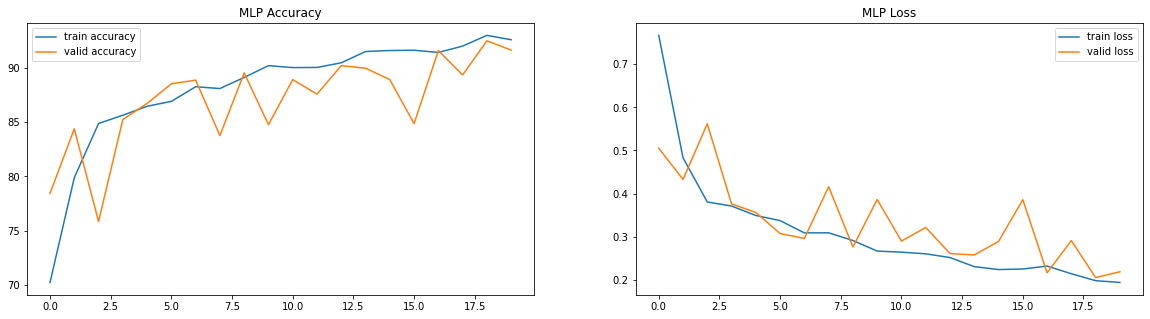

In [13]:
writer = SummaryWriter(f'./runs')
sgd_results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, valid_loader, loss_fn, sgd_opt, sgd_results, model_name="MLP", model=nn_model, epochs=num_epoch, writer=writer, device=device)
writer.close()

In [14]:
sgd_results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
valid_loop(test_loader, nn_model, loss_fn, sgd_results, device=device, mode="test")

Test Metrics: 
 Accuracy: 91.1%, Avg loss: 0.241407 

 Precision: 91.1%, Recall: 91.1%


- Confusion Matrix
- Num of parameters

In [15]:
y_true = []
y_pred = []
nn_model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        y_true.extend(y.data.cpu().tolist())
        pred = nn_model(X)
        y_pred.extend(pred.argmax(1).data.cpu().tolist())

classes = ['Boot', 'Sandal', 'Shoe']
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 100, index = [i for i in classes],
                     columns = [i for i in classes])
print('Confusion Matrix \n')
print(df_cm)

total_params = sum(p.numel() for p in nn_model.parameters() if p.requires_grad)
print(f"Number of MLP's Parameters: {total_params:,}")

Confusion Matrix 

             Boot     Sandal       Shoe
Boot    31.511111   1.088889   0.644444
Sandal   1.311111  28.488889   2.511111
Shoe     1.377778   1.933333  31.133333
Number of MLP's Parameters: 21,834,755


- Train Accuracy : 93.4%
- Test Accuracy : 90.8%

# Part C
- Tensorboard

In [16]:
!tensorboard --logdir=runs

- You can run cell above and go to link
- Images below are screenshots for assuring you about result of Tensorboard

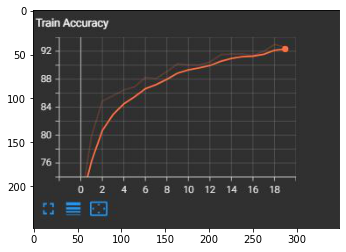

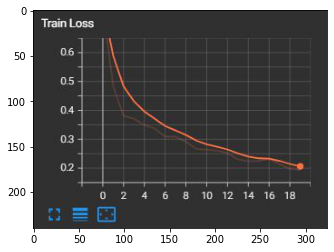

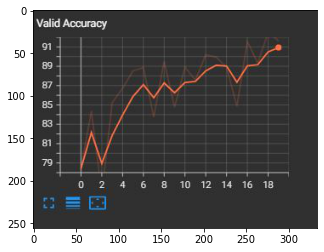

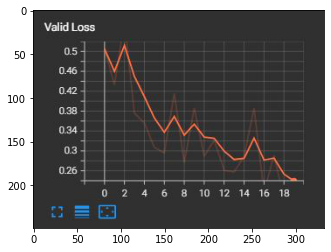

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
plt.figure(1)
img = plt.imread('Capture1.JPG')
plt.imshow(img)
plt.figure(2)
img = plt.imread('Capture2.JPG')
plt.imshow(img)
plt.figure(3)
img = plt.imread('Capture3.JPG')
plt.imshow(img)
plt.figure(4)
img = plt.imread('Capture4.JPG')
plt.imshow(img)

# Part D
- Making CNN network
- Reporting four metrics in each epoch
- Plotting loss and accuracy diagram
- Confusion matrix
- Number of parameters
- Tensorboard

In [17]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn,self).__init__()
        
        self.conv1 = nn.Conv2d(3,16,kernel_size = 3)
        self.batch1 = nn.BatchNorm2d(16) 
        self.rel1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16,32,kernel_size = 3)
        self.batch2 = nn.BatchNorm2d(32)
        self.rel2 = nn.ReLU()
        
        self.maxp2 = nn.MaxPool2d(kernel_size = 2)
        
        self.conv3 = nn.Conv2d(32,64,kernel_size = 2)
        self.batch3 = nn.BatchNorm2d(64)
        self.rel3 = nn.ReLU()
        
        self.drop3 = nn.Dropout(0.2)
        
        self.flatten = nn.Flatten()
        
        self.fc = nn.Linear(64*97*131,3)
        
    def forward(self,inputs):
        
        x = self.conv1(inputs)
        x = self.batch1(x)
        x = self.rel1(x)
        
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.rel2(x)
        
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.rel3(x)
        x = self.drop3(x)
        x = self.flatten(x)
        
        x = self.fc(x)
        
        return(x)

cnn_model = cnn()
summary(cnn_model.to(device), (3,102,136))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 100, 134]        448
├─BatchNorm2d: 1-2                       [-1, 16, 100, 134]        32
├─ReLU: 1-3                              [-1, 16, 100, 134]        --
├─Conv2d: 1-4                            [-1, 32, 98, 132]         4,640
├─BatchNorm2d: 1-5                       [-1, 32, 98, 132]         64
├─ReLU: 1-6                              [-1, 32, 98, 132]         --
├─Conv2d: 1-7                            [-1, 64, 97, 131]         8,256
├─BatchNorm2d: 1-8                       [-1, 64, 97, 131]         128
├─ReLU: 1-9                              [-1, 64, 97, 131]         --
├─Dropout: 1-10                          [-1, 64, 97, 131]         --
├─Flatten: 1-11                          [-1, 813248]              --
├─Linear: 1-12                           [-1, 3]                   2,439,747
Total params: 2,453,315
Trainable params: 2,453,315
Non-trainable para

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 100, 134]        448
├─BatchNorm2d: 1-2                       [-1, 16, 100, 134]        32
├─ReLU: 1-3                              [-1, 16, 100, 134]        --
├─Conv2d: 1-4                            [-1, 32, 98, 132]         4,640
├─BatchNorm2d: 1-5                       [-1, 32, 98, 132]         64
├─ReLU: 1-6                              [-1, 32, 98, 132]         --
├─Conv2d: 1-7                            [-1, 64, 97, 131]         8,256
├─BatchNorm2d: 1-8                       [-1, 64, 97, 131]         128
├─ReLU: 1-9                              [-1, 64, 97, 131]         --
├─Dropout: 1-10                          [-1, 64, 97, 131]         --
├─Flatten: 1-11                          [-1, 813248]              --
├─Linear: 1-12                           [-1, 3]                   2,439,747
Total params: 2,453,315
Trainable params: 2,453,315
Non-trainable para

In [18]:
loss_fn = nn.CrossEntropyLoss()
sgd_learning_rate = lr
sgd_opt = torch.optim.SGD(cnn_model.parameters(), lr=sgd_learning_rate, momentum=0.9)

CNN
-------------------------------
Epoch 1
-------------------------------
loss: 1.176518  [    0/ 8400]
Train Metrics: 
 Accuracy: 79.7%, Avg loss: 6.491919
 Precision: 79.6%, Recall: 79.6%
Validation Metrics: 
 Accuracy: 85.0%, Avg loss: 4.121468 

 Precision: 85.5%, Recall: 85.2%
---------------------------------------------
Epoch 2
-------------------------------
loss: 0.401071  [    0/ 8400]
Train Metrics: 
 Accuracy: 92.2%, Avg loss: 1.556514
 Precision: 92.2%, Recall: 92.2%
Validation Metrics: 
 Accuracy: 88.8%, Avg loss: 1.407116 

 Precision: 89.1%, Recall: 88.9%
---------------------------------------------
Epoch 3
-------------------------------
loss: 0.555095  [    0/ 8400]
Train Metrics: 
 Accuracy: 95.0%, Avg loss: 0.553510
 Precision: 95.0%, Recall: 95.0%
Validation Metrics: 
 Accuracy: 92.2%, Avg loss: 1.320760 

 Precision: 92.5%, Recall: 92.4%
---------------------------------------------
Epoch 4
-------------------------------
loss: 0.522684  [    0/ 8400]
Train Met

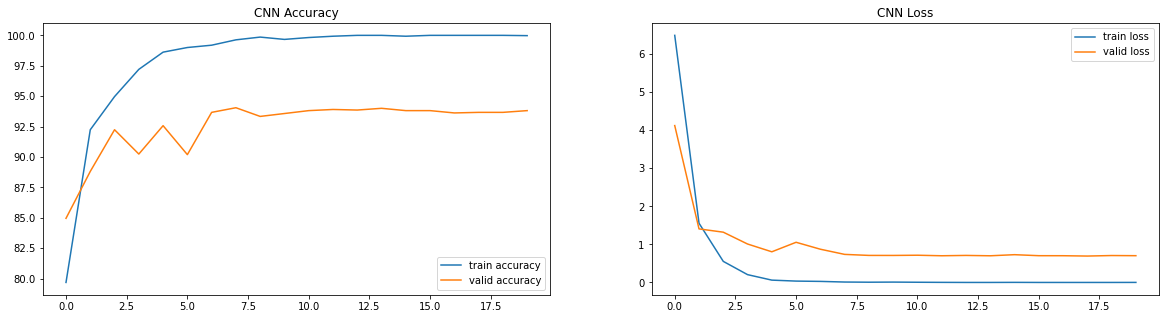

In [19]:
writer = SummaryWriter(f'runs_CNN')
sgd_results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, valid_loader, loss_fn, sgd_opt, sgd_results, model_name="CNN", model=cnn_model, epochs=num_epoch, writer=writer, device=device)
writer.close()

In [20]:
sgd_results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
valid_loop(test_loader, cnn_model, loss_fn, sgd_results, device=device, mode="test")

Test Metrics: 
 Accuracy: 93.7%, Avg loss: 0.683620 

 Precision: 93.7%, Recall: 93.6%


- Train Accuracy : 100%
- Test Accuracy : 94.4%

In [21]:
y_true = []
y_pred = []
cnn_model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        y_true.extend(y.data.cpu().tolist())
        pred = cnn_model(X)
        y_pred.extend(pred.argmax(1).data.cpu().tolist())

classes = ['Boot', 'Sandal', 'Shoe']
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 100, index = [i for i in classes],
                     columns = [i for i in classes])
print('Confusion Matrix \n')
print(df_cm)

total_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
print(f"Number of CNN's Parameters: {total_params:,}")

Confusion Matrix 

             Boot     Sandal       Shoe
Boot    31.955556   0.600000   0.688889
Sandal   0.644444  29.511111   2.155556
Shoe     0.688889   1.555556  32.200000
Number of CNN's Parameters: 2,453,315


In [22]:
!tensorboard --logdir=runs_CNN

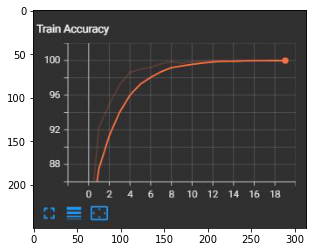

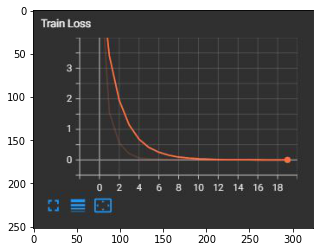

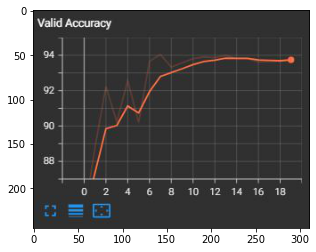

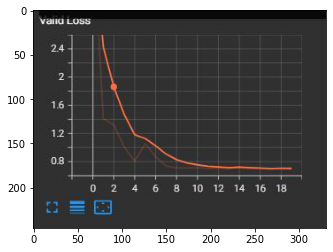

In [18]:
from PIL import Image
import matplotlib.pyplot as plt
plt.figure(1)
img = plt.imread('Capture5.JPG')
plt.imshow(img)
plt.figure(2)
img = plt.imread('Capture6.JPG')
plt.imshow(img)
plt.figure(3)
img = plt.imread('Capture7.JPG')
plt.imshow(img)
plt.figure(4)
img = plt.imread('Capture8.JPG')
plt.imshow(img)

# Part E
### Comparing the results between MLP and CNN
---------------------------------------------
- As you can see, CNN network is more efficient than MLP network when we want to extract features from images.
- The results shows that we can get better results(accuracy,...) when we use conv layers.
- The diffrence between parameters are so significant but, with much less parameters CNN is better than MLP.


# Part F
- Adding Block Dropout to our CNN network.

## Why using Block Dropout is a better choice in CNN networks?
- DropBlock is a structured form of dropout directed at regularizing convolutional networks. In DropBlock, units in a contiguous region of a feature map are dropped together. As DropBlock discards features in a correlated area, the networks must look elsewhere for evidence to fit the data.

In [23]:
#!pip install dropblock

In [24]:
class DropBlock2D(nn.Module):
    r"""Randomly zeroes 2D spatial blocks of the input tensor.
    As described in the paper
    `DropBlock: A regularization method for convolutional networks`_ ,
    dropping whole blocks of feature map allows to remove semantic
    information as compared to regular dropout.
    Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, H, W)`
        - Output: `(N, C, H, W)`
    .. _DropBlock: A regularization method for convolutional networks:
       https://arxiv.org/abs/1810.12890
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)

## Explanation
- We can use dropblock or above class, both of them are same 

In [25]:
#from dropblock import DropBlock2D
class cnn_blockdrop(nn.Module):
    def __init__(self):
        super(cnn_blockdrop,self).__init__()
        
        self.conv1 = nn.Conv2d(3,16,kernel_size = 3)
        self.batch1 = nn.BatchNorm2d(16) 
        self.rel1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16,32,kernel_size = 3)
        self.batch2 = nn.BatchNorm2d(32)
        self.rel2 = nn.ReLU()
        
        self.maxp2 = nn.MaxPool2d(kernel_size = 2)
        
        self.conv3 = nn.Conv2d(32,64,kernel_size = 2)
        self.batch3 = nn.BatchNorm2d(64)
        self.rel3 = nn.ReLU()
        
        #self.drop3 = nn.Dropout(0.2)
        self.drop_block = DropBlock2D(block_size=3, drop_prob=0.2)
        
        self.flatten = nn.Flatten()
        
        self.fc = nn.Linear(64*97*131,3)
        
    def forward(self,inputs):
        
        x = self.conv1(inputs)
        x = self.batch1(x)
        x = self.rel1(x)
        
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.rel2(x)
        
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.rel3(x)
        x = self.drop_block(x)
        x = self.flatten(x)
        x = self.fc(x)
        
        return(x)

cnn_bdrop = cnn_blockdrop()
print(summary(cnn_bdrop.to(device), (3,102,136)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 100, 134]        448
├─BatchNorm2d: 1-2                       [-1, 16, 100, 134]        32
├─ReLU: 1-3                              [-1, 16, 100, 134]        --
├─Conv2d: 1-4                            [-1, 32, 98, 132]         4,640
├─BatchNorm2d: 1-5                       [-1, 32, 98, 132]         64
├─ReLU: 1-6                              [-1, 32, 98, 132]         --
├─Conv2d: 1-7                            [-1, 64, 97, 131]         8,256
├─BatchNorm2d: 1-8                       [-1, 64, 97, 131]         128
├─ReLU: 1-9                              [-1, 64, 97, 131]         --
├─DropBlock2D: 1-10                      [-1, 64, 97, 131]         --
├─Flatten: 1-11                          [-1, 813248]              --
├─Linear: 1-12                           [-1, 3]                   2,439,747
Total params: 2,453,315
Trainable params: 2,453,315
Non-trainable para

In [26]:
loss_fn = nn.CrossEntropyLoss()
sgd_learning_rate = lr
sgd_opt = torch.optim.SGD(cnn_bdrop.parameters(), lr=sgd_learning_rate, momentum=0.9)

CNN+DropBlock
-------------------------------
Epoch 1
-------------------------------
loss: 1.061709  [    0/ 8400]
Train Metrics: 
 Accuracy: 77.9%, Avg loss: 7.710307
 Precision: 77.8%, Recall: 77.8%
Validation Metrics: 
 Accuracy: 77.0%, Avg loss: 5.450878 

 Precision: 81.4%, Recall: 77.5%
---------------------------------------------
Epoch 2
-------------------------------
loss: 2.122605  [    0/ 8400]
Train Metrics: 
 Accuracy: 88.4%, Avg loss: 2.085168
 Precision: 88.4%, Recall: 88.4%
Validation Metrics: 
 Accuracy: 90.8%, Avg loss: 1.180370 

 Precision: 90.9%, Recall: 90.9%
---------------------------------------------
Epoch 3
-------------------------------
loss: 1.587558  [    0/ 8400]
Train Metrics: 
 Accuracy: 92.7%, Avg loss: 0.741205
 Precision: 92.7%, Recall: 92.7%
Validation Metrics: 
 Accuracy: 90.4%, Avg loss: 0.871387 

 Precision: 90.8%, Recall: 90.6%
---------------------------------------------
Epoch 4
-------------------------------
loss: 0.433189  [    0/ 8400]

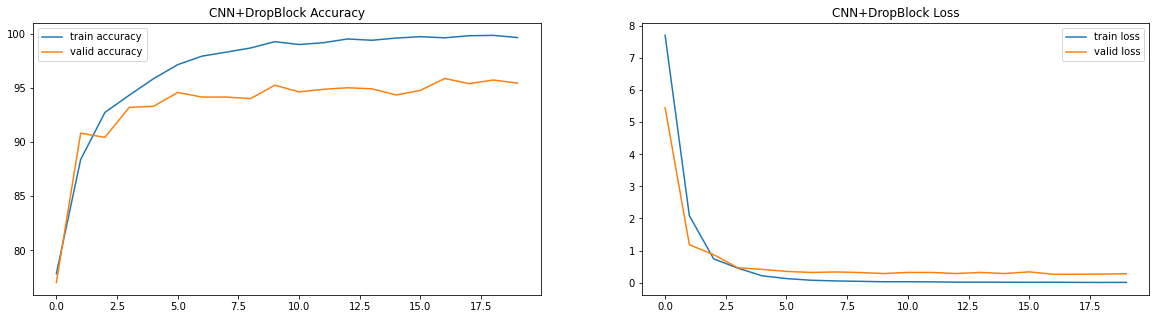

In [27]:
#writer = SummaryWriter(f'SobhanRuns/Shoes/CNN+DropBlock')
sgd_results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, valid_loader, loss_fn, sgd_opt, sgd_results, model_name="CNN+DropBlock", model=cnn_bdrop, epochs=num_epoch, writer=None, device=device)

In [28]:
sgd_results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
valid_loop(test_loader, cnn_bdrop, loss_fn, sgd_results, device=device, mode="test")

Test Metrics: 
 Accuracy: 94.6%, Avg loss: 0.307478 

 Precision: 94.6%, Recall: 94.6%


In [29]:
y_true = []
y_pred = []
cnn_bdrop.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        y_true.extend(y.data.cpu().tolist())
        pred = cnn_bdrop(X)
        y_pred.extend(pred.argmax(1).data.cpu().tolist())

classes = ['Boot', 'Sandal', 'Shoe']
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 100, index = [i for i in classes],
                     columns = [i for i in classes])
print('Confusion Matrix \n')
print(df_cm)

total_params = sum(p.numel() for p in cnn_bdrop.parameters() if p.requires_grad)
print(f"Number of CNN+BlockDropout's Parameters: {total_params:,}")

Confusion Matrix 

             Boot     Sandal       Shoe
Boot    32.244444   0.511111   0.488889
Sandal   0.400000  30.444444   1.466667
Shoe     0.511111   2.000000  31.933333
Number of CNN+BlockDropout's Parameters: 2,453,315


- Train Accuracy : 99.8%
- Test Accuracy : 95%
- The results shows that we have less Generalization error and better test accuracy when we use DropBlock

# Part G
- Kernel Factorization

In [30]:
class cnn_kernelfactor(nn.Module):
    def __init__(self):
        super(cnn_kernelfactor,self).__init__()
        
        self.conv1 = nn.Conv2d(3,16,kernel_size = (3, 1))
        self.rel1_1 = nn.ReLU()
        self.conv1_1 = nn.Conv2d(16,16,kernel_size = (1, 3), groups=16)
        self.batch1 = nn.BatchNorm2d(16) 
        self.rel1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16,32,kernel_size = (3, 1))
        self.rel2_1 = nn.ReLU()
        self.conv2_1 = nn.Conv2d(32,32,kernel_size = (1, 3), groups=32)
        self.batch2 = nn.BatchNorm2d(32)
        self.rel2 = nn.ReLU()
        
        self.maxp2 = nn.MaxPool2d(kernel_size = 2)
        
        self.conv3 = nn.Conv2d(32,64,kernel_size = (2, 1))
        self.rel3_1 = nn.ReLU()
        self.conv3_1 = nn.Conv2d(64,64,kernel_size = (1, 2), groups=64)
        self.batch3 = nn.BatchNorm2d(64)
        self.rel3 = nn.ReLU()
        
        #self.drop3 = nn.Dropout(0.2)
        self.drop_block = DropBlock2D(block_size=3, drop_prob=0.2)
        
        self.flatten = nn.Flatten()
        
        self.fc = nn.Linear(64*97*131,3)
        
    def forward(self,inputs):
        
        x = self.conv1(inputs)
        x = self.rel1_1(x)
        x = self.conv1_1(x)
        x = self.batch1(x)
        x = self.rel1(x)
        
        x = self.conv2(x)
        x = self.rel2_1(x)
        x = self.conv2_1(x)
        x = self.batch2(x)
        x = self.rel2(x)
        x = self.conv3(x)
        x = self.rel3_1(x)
        x = self.conv3_1(x)
        x = self.batch3(x)
        x = self.rel3(x)
        
        x = self.drop_block(x)
        
        x = self.flatten(x)
        
        x = self.fc(x)
        
        return(x)

cnn_kfactor = cnn_kernelfactor()
print(summary(cnn_kfactor.to(device), (3,102,136)))
#print(cnn_kfactor)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 100, 136]        160
├─ReLU: 1-2                              [-1, 16, 100, 136]        --
├─Conv2d: 1-3                            [-1, 16, 100, 134]        64
├─BatchNorm2d: 1-4                       [-1, 16, 100, 134]        32
├─ReLU: 1-5                              [-1, 16, 100, 134]        --
├─Conv2d: 1-6                            [-1, 32, 98, 134]         1,568
├─ReLU: 1-7                              [-1, 32, 98, 134]         --
├─Conv2d: 1-8                            [-1, 32, 98, 132]         128
├─BatchNorm2d: 1-9                       [-1, 32, 98, 132]         64
├─ReLU: 1-10                             [-1, 32, 98, 132]         --
├─Conv2d: 1-11                           [-1, 64, 97, 132]         4,160
├─ReLU: 1-12                             [-1, 64, 97, 132]         --
├─Conv2d: 1-13                           [-1, 64, 97, 131]         192
├─Batc

In [31]:
loss_fn = nn.CrossEntropyLoss()
sgd_learning_rate = lr
sgd_opt = torch.optim.SGD(cnn_kfactor.parameters(), lr=sgd_learning_rate, momentum=0.9)

CNN+KernelFactorization
-------------------------------
Epoch 1
-------------------------------
loss: 1.220555  [    0/ 8400]
Train Metrics: 
 Accuracy: 83.8%, Avg loss: 2.661725
 Precision: 83.7%, Recall: 83.7%
Validation Metrics: 
 Accuracy: 87.2%, Avg loss: 1.450272 

 Precision: 88.9%, Recall: 87.4%
---------------------------------------------
Epoch 2
-------------------------------
loss: 0.118957  [    0/ 8400]
Train Metrics: 
 Accuracy: 94.3%, Avg loss: 0.528804
 Precision: 94.3%, Recall: 94.3%
Validation Metrics: 
 Accuracy: 93.4%, Avg loss: 0.644967 

 Precision: 93.5%, Recall: 93.5%
---------------------------------------------
Epoch 3
-------------------------------
loss: 0.076651  [    0/ 8400]
Train Metrics: 
 Accuracy: 98.3%, Avg loss: 0.110010
 Precision: 98.3%, Recall: 98.3%
Validation Metrics: 
 Accuracy: 94.7%, Avg loss: 0.660874 

 Precision: 94.9%, Recall: 94.8%
---------------------------------------------
Epoch 4
-------------------------------
loss: 0.001050  [  

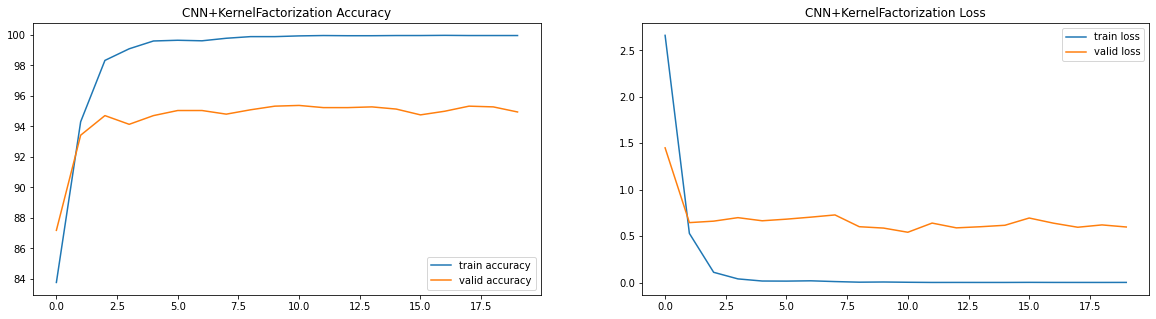

In [32]:
#writer = SummaryWriter(f'SobhanRuns/Shoes/CNN+KernelFactorization')
sgd_results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, valid_loader, loss_fn, sgd_opt, sgd_results, model_name="CNN+KernelFactorization", model=cnn_kfactor, epochs=num_epoch, writer=None, device=device)

In [33]:
sgd_results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
valid_loop(test_loader, cnn_kfactor, loss_fn, sgd_results, device=device, mode="test")

Test Metrics: 
 Accuracy: 95.1%, Avg loss: 0.561766 

 Precision: 95.1%, Recall: 95.1%


In [34]:
y_true = []
y_pred = []
cnn_kfactor.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        y_true.extend(y.data.cpu().tolist())
        pred = cnn_kfactor(X)
        y_pred.extend(pred.argmax(1).data.cpu().tolist())

classes = ['Boot', 'Sandal', 'Shoe']
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 100, index = [i for i in classes],
                     columns = [i for i in classes])
print('Confusion Matrix \n')
print(df_cm)

total_params = sum(p.numel() for p in cnn_kfactor.parameters() if p.requires_grad)
print(f"Number of CNN+KernelFactorization's Parameters: {total_params:,}")

Confusion Matrix 

             Boot     Sandal       Shoe
Boot    32.088889   0.711111   0.444444
Sandal   0.377778  30.711111   1.222222
Shoe     0.511111   1.600000  32.333333
Number of CNN+KernelFactorization's Parameters: 2,446,243


### Concluding from using Kernel factorization in our network
- Results show that we have better results than before.
- Using kernel factorization add more non-linearity to our network and it's better for our task.
- In this Method we have two activation functions instead of one.
- Instead of using one (3,3) kernel we use (3,1) and (1,3) kernels.
- Before (3,3) kenel has 9 parameters but now we have (2,3) parameters.
- The Number of parameters has decreased when we are using Kernel Factorization